In [1]:
import random
import timm
import numpy
from PIL import Image
import albumentations
import json
import torch
import torch.nn as nn
from sklearn.metrics import roc_curve, roc_auc_score, auc
from albumentations.pytorch import ToTensorV2
import numpy as np
import cv2
import os
import torchvision.transforms
import torchvision
import scipy
from src.helper import DEFAULT_GLAUCOMATOUS_FEATURES, inference_tasks

from matplotlib import pyplot as plt

In [2]:
def load_model(CFG):
    state_dict = torch.load(CFG['checkpoint'])
    model = timm.create_model(CFG['model_name'], pretrained=False, num_classes=11)

    if 'efficient' in CFG['model_name']:
        model.classifier = nn.Sequential(model.classifier, nn.Sigmoid())
        model.load_state_dict(state_dict, strict=True)

    elif 'convnext' in CFG['model_name']:
        model.head.fc = nn.Sequential(model.head.fc, nn.Sigmoid())
        try:
            # model = nn.DataParallel(model)
            model.load_state_dict(state_dict, strict=True)

        except Exception as e:
            print(e)
            model.load_state_dict(state_dict, strict=False)
            model.head.fc.weight = torch.nn.Parameter(state_dict['head.fc.0.weight'])
            model.head.fc.bias = torch.nn.Parameter(state_dict['head.fc.0.bias'])

    return model


def crop_image1(img, tol=7):
    mask = img > tol
    return img[np.ix_(mask.any(1), mask.any(0))]


class Model_Ensemble:
    def __init__(self, models):
        self.models = models
    def __call__(self, x):
        res = []
        x = x.cuda()
        with torch.no_grad():
            for m in self.models:
                m.eval()
                re = m(x)
                if type(re)==type(tuple([1,1])):
                    re = re[-1]
                res.append(re)
            try:
                res = torch.stack(res)
            except:
                res = torch.stack(res[0])
            return torch.mean(res, dim=0)


def crop_image_from_gray(img, tol=7):
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol

        check_shape = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if (check_shape == 0): 
            return img 
        else:
            img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]
            img = np.stack([img1, img2, img3], axis=-1)
        return img


def torch_flip_lr(images):
    return torchvision.transforms.functional.hflip(images)
def torch_shift(images, shift, axis=1):
    return torch.roll(images, shift, dims=[axis, ])
def torch_rotate(images, angle):
    return torchvision.transforms.functional.rotate(images, angle)

test_transform = albumentations.Compose([
    albumentations.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

In [3]:
DEFAULT_GLAUCOMATOUS_FEATURES = {
    "appearance neuroretinal rim superiorly": None,
    "appearance neuroretinal rim inferiorly": None,
    "retinal nerve fiber layer defect superiorly": None,
    "retinal nerve fiber layer defect inferiorly": None,
    "baring of the circumlinear vessel superiorly": None,
    "baring of the circumlinear vessel inferiorly": None,
    "nasalization of the vessel trunk": None,
    "disc hemorrhages": None,
    "laminar dots": None,
    "large cup": None,
}

In [4]:
model_info_list = [
    {
        'image_size':1024,
        'cfg_path_local':     './src/weights/convnext_tiny__IMGSIZE_1024__fold_1__lr_5e06__final_header_Eval__justification_header_Eval.json',
        'weights_path_local': './src/weights/epoch_0_weight_best_0.9317073170731708.pt',
        'justification_thresholds': [0.4646, 0.305, 0.5114, 0.6, 0.5521, 0.6768, 0.5418, 0.6, 0.5862, 0.6539],
        'justification_thresholds_TTA': [0.3968, 0.3018, 0.5063, 0.6, 0.5526, 0.6466, 0.4536, 0.6, 0.6169, 0.6768],
    },
    {  
        'image_size':896,
        'cfg_path_local':     './src/weights/convnext_tiny__IMGSIZE_896__fold_0__lr_5e06__final_header_Eval__justification_header_Eval.json',
        'weights_path_local': './src/weights/epoch_0_weight_best_0.9472817133443163.pt',
        'justification_thresholds': [0.3681, 0.2146, 0.5, 0.6, 0.6495, 0.6203, 0.3608, 0.6, 0.5062, 0.6324],
        'justification_thresholds_TTA': [0.359 , 0.1598, 0.4261, 0.6, 0.6361, 0.6, 0.3186, 0.6, 0.4732, 0.617],
        
    },
    {
        'image_size':896,
        'cfg_path_local':     './src/weights/full_data_rotate_15dgr_convnext_tiny__IMGSIZE_896__fold_1__lr_5e06__final_header_Smooth__justification_header_Smooth.json',
        'weights_path_local': './src/weights/epoch_0_weight_best_0.9496183206106871.pt',
        'justification_thresholds': [0.4282, 0.4478, 0.7328, 0.6262, 0.5153, 0.6, 0.6165, 0.6, 0.6388, 0.7586],
        'justification_thresholds_TTA': [0.5418, 0.5137, 0.6695, 0.7347, 0.4979, 0.5365, 0.6032, 0.6, 0.6248, 0.7589],
    },
    {
        'image_size':1024,
        'cfg_path_local':     './src/weights/full_data_rotate_15dgr_convnext_tiny__IMGSIZE_1024__fold_3__lr_5e06__final_header_Smooth__justification_header_Smooth.json',
        'weights_path_local': './src/weights/epoch_0_weight_best_0.9346092503987241.pt',
        'justification_thresholds': [0.2539, 0.6276, 0.3802, 0.6, 0.5487, 0.6125, 0.7946, 0.1933, 0.6079, 0.5555],
        'justification_thresholds_TTA': [0.2754, 0.5949, 0.3805, 0.6, 0.4756, 0.6, 0.7886, 0.6, 0.6038, 0.5732],  
    },    
    {
        'image_size':896,
        'cfg_path_local':     './src/weights/full_data_convnext_tiny__IMGSIZE_896__fold_4__lr_5e06__final_header_Eval__justification_header_Eval.json',
        'weights_path_local': './src/weights/epoch_0_weight_best_0.9362363919129082.pt',
        'justification_thresholds': [0.1341, 0.5891, 0.5615, 0.6, 0.6, 0.6, 0.5272, 0.6, 0.6708, 0.6541],
        'justification_thresholds_TTA': [0.1595, 0.5683, 0.4293, 0.6, 0.6937, 0.5321, 0.489 , 0.6, 0.6088, 0.6561],
    },
    { 
        'image_size':896,
        'cfg_path_local':     './src/weights/convnext_tiny__IMGSIZE_896__fold_1__lr_5e06__final_header_Smooth__justification_header_Smooth.json',
        'weights_path_local': './src/weights/epoch_1_weight_best_0.9382113821138212.pt',
        'justification_thresholds': [0.508, 0.37 , 0.614, 0.676, 0.697, 0.75 , 0.754, 0.171, 0.531, 0.814],
        'justification_thresholds_TTA': [0.42 , 0.366, 0.6  , 0.678, 0.692, 0.723, 0.758, 0.164, 0.519, 0.821],
    },
    {  
        'image_size':896,
        'cfg_path_local':     './src/weights/convnext_tiny__IMGSIZE_896__fold_4__lr_5e06__final_header_Smooth__justification_header_Smooth.json',
        'weights_path_local': './src/weights/epoch_0_weight_best_0.9347079037800687.pt',
        'justification_thresholds': [0.508, 0.37 , 0.614, 0.676, 0.697, 0.75 , 0.754, 0.171, 0.531, 0.814],
        'justification_thresholds_TTA': [0.42 , 0.366, 0.6  , 0.678, 0.692, 0.723, 0.758, 0.164, 0.519, 0.821],
    },
    {
       'image_size': 896,
        'cfg_path_local': './src/weights/fold_0_convnext_tiny_epoch_0_weight_best_0.9538714991762768.json',
        'weights_path_local': './src/weights/epoch_0_weight_best_0.9538714991762768.pt',
        'justification_thresholds': [0.508, 0.37, 0.614, 0.676, 0.697, 0.75, 0.754, 0.171, 0.531, 0.814],
        'justification_thresholds_TTA': [0.42, 0.366, 0.6, 0.678, 0.692, 0.723, 0.758, 0.164, 0.519, 0.821],
    },
]

In [5]:
for model_info in model_info_list:
    assert os.path.exists(model_info['cfg_path_local']), model_info['cfg_path_local']
    assert os.path.exists(model_info['weights_path_local']), model_info['weights_path_local']
    with open(model_info['cfg_path_local']) as f:
        CFG = json.load(f)
    model_info['CFG'] = CFG
    model_info['CFG']['checkpoint'] = model_info['weights_path_local']
    model_info['model'] = load_model(model_info['CFG']).cuda()    

De-Stacked /tmp/tmpcn4tu7hu/image_1.jpg
De-Stacked /tmp/tmpcn4tu7hu/image_2.jpg
De-Stacked /tmp/tmpcn4tu7hu/image_3.jpg
/tmp/tmpcn4tu7hu/image_1.jpg
is_referable_glaucoma_likelihood 0.023016488179564476
False appearance neuroretinal rim superiorly
False appearance neuroretinal rim inferiorly
False retinal nerve fiber layer defect superiorly
False retinal nerve fiber layer defect inferiorly
False baring of the circumlinear vessel superiorly
False baring of the circumlinear vessel inferiorly
False nasalization of the vessel trunk
False disc hemorrhages
False laminar dots
False large cup


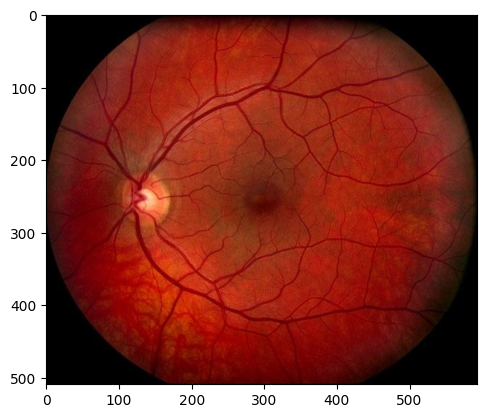

In [6]:
from src.helper import stack_inference
for jpg_image_file_name, _ in stack_inference('src/test/input/stacked-color-fundus-images/images/bd658ff4-d26f-4f08-ad6b-861e6f3e7c26.tiff', None):
    print(jpg_image_file_name)

    # For example: use Pillow to read the jpg file and convert it to a NumPY array:
    image = Image.open(jpg_image_file_name)
    numpy_array_ = numpy.array(image)
    
    numpy_array_ = crop_image_from_gray(numpy_array_)
    numpy_array_896 = cv2.resize(numpy_array_,  (896,  896))
    numpy_array_1024 = cv2.resize(numpy_array_, (1024, 1024))
    
    
    
    # 1024
    numpy_array_transformed = test_transform(image=numpy_array_1024)['image']
    imgs_valid_f =  torch_flip_lr(numpy_array_transformed)
    imgs_valid_w0 = torch_shift(numpy_array_transformed, -3, axis=2)
    imgs_valid_w1 = torch_shift(numpy_array_transformed, 3, axis=2)
    imgs_valid_h0 = torch_shift(numpy_array_transformed, -3, axis=1)
    imgs_valid_h1 = torch_shift(numpy_array_transformed, 3, axis=1)
    imgs_valid_r0 = torch_rotate(numpy_array_transformed, -10)
    imgs_valid_r1 = torch_rotate(numpy_array_transformed, 10)
    image_valid_with_tta_1024 = torch.stack([
        numpy_array_transformed, imgs_valid_f, imgs_valid_w0,
        imgs_valid_w1, imgs_valid_h0,
        imgs_valid_h1, imgs_valid_r0, imgs_valid_r1]).squeeze(1)
    
    # 896
    numpy_array_transformed = test_transform(image=numpy_array_896)['image']
    imgs_valid_f =  torch_flip_lr(numpy_array_transformed)
    imgs_valid_w0 = torch_shift(numpy_array_transformed, -3, axis=2)
    imgs_valid_w1 = torch_shift(numpy_array_transformed, 3, axis=2)
    imgs_valid_h0 = torch_shift(numpy_array_transformed, -3, axis=1)
    imgs_valid_h1 = torch_shift(numpy_array_transformed, 3, axis=1)
    imgs_valid_r0 = torch_rotate(numpy_array_transformed, -10)
    imgs_valid_r1 = torch_rotate(numpy_array_transformed, 10)
    image_valid_with_tta_896 = torch.stack([
        numpy_array_transformed, imgs_valid_f, imgs_valid_w0,
        imgs_valid_w1, imgs_valid_h0,
        imgs_valid_h1, imgs_valid_r0, imgs_valid_r1]).squeeze(1)
    
    # Run inference on each transformation of the original test image
    with torch.no_grad():
    
        referable_glaucoma_proba_list = list()
        justification_labels_list = list()
        for model_info in model_info_list:
            model = model_info['model']
            if model_info['image_size'] == 896:
                model_output = model(image_valid_with_tta_896.cuda())
            elif model_info['image_size'] == 1024:
                model_output = model(image_valid_with_tta_1024.cuda())
            else:
                raise NotImplementedError
    
            # average the TTA proba
            model_output = model_output.mean(0).cpu().numpy() # shape (8,11) -> shape (11)
            model_referable_glaucoma_output_proba = model_output[0] # shape (11) -> shape (1)
            model_justification_output = model_output[1:] # shape (11) -> shape (10)
            model_justification_output = model_justification_output > np.array(model_info['justification_thresholds'])
    
            referable_glaucoma_proba_list.append(model_referable_glaucoma_output_proba)
            justification_labels_list.append(model_justification_output)
    
    ensemble_referable_glaucoma_proba = np.stack(referable_glaucoma_proba_list[1:]).mean(0)
    ensemble_justification_vote = np.array(justification_labels_list[0:5]).astype(int).sum(0)
    
    is_referable_glaucoma_likelihood = float(ensemble_referable_glaucoma_proba)
    is_referable_glaucoma_threshold = np.mean([model_info['justification_thresholds'][0] for model_info in model_info_list])
    is_referable_glaucoma = bool(float(is_referable_glaucoma_likelihood) > float(is_referable_glaucoma_threshold))
    
    
    features = {
        k: bool(int(ensemble_justification_vote[feature_idx] >= 3))
        for (feature_idx, (k, v)) in enumerate(DEFAULT_GLAUCOMATOUS_FEATURES.items())
    }

    
    break

plt.imshow(numpy_array_)
print('is_referable_glaucoma_likelihood', is_referable_glaucoma_likelihood)
for feature_name in features.keys():
    print(features[feature_name], feature_name)